# Custom TransferLearning using DenseNet201

In [1]:
import tensorflow as tf

from tensorflow.keras.applications import InceptionResNetV2

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carga de los datos para el entrenamiento

In [3]:
img_size = 299
batch_size = 4
path_train = 'data_' + str(img_size) + '/train'
path_test_validation = 'data_' + str(img_size) + '/validation'

In [4]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    path_train,
    target_size=(img_size, img_size),
    batch_size=batch_size)

val_generator = datagen_val.flow_from_directory(
    path_test_validation,
    target_size=(img_size, img_size),
    batch_size=batch_size)

Found 12000 images belonging to 5 classes.
Found 1515 images belonging to 5 classes.


## Mostrando los labels que van a ser entrenados

In [5]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

labels = '\n'.join(sorted(train_generator.class_indices.keys()))
print(labels)

10
100
20
200
50


In [6]:
# numero de clases a entrenar
num_classes = len(train_generator.class_indices.keys())

In [7]:
base_model = InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size,img_size,3)
)

219062272/219055592 [==============================] - 29s 0us/step


In [8]:
base_model.trainable = False

In [9]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

# Empezando el entrenamiento

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D

In [11]:
model = tf.keras.Sequential([
  base_model,
  Flatten(),
  Dense(512, activation='relu'),
  Dropout(0.4),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(32, activation='relu'),
  Dense(num_classes, activation='softmax')
])

## Compilamos el modelo

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #default learning_rate = 0.001
loss = 'categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, 
              loss=loss, 
              metrics=metrics)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               50332160  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [14]:
epochs = 10
history = model.fit(train_generator, 
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_generator)

Epoch 1/10
3000/3000 [==============================] - 148s 49ms/step - loss: 0.4680 - accuracy: 0.8413 - val_loss: 3.8412 - val_accuracy: 0.4145
Epoch 2/10
3000/3000 [==============================] - 146s 49ms/step - loss: 0.1092 - accuracy: 0.9653 - val_loss: 6.8137 - val_accuracy: 0.3901
Epoch 3/10
3000/3000 [==============================] - 149s 50ms/step - loss: 0.0726 - accuracy: 0.9776 - val_loss: 5.7936 - val_accuracy: 0.4370
Epoch 4/10
3000/3000 [==============================] - 151s 50ms/step - loss: 0.0562 - accuracy: 0.9824 - val_loss: 7.8432 - val_accuracy: 0.3927
Epoch 5/10
3000/3000 [==============================] - 150s 50ms/step - loss: 0.0465 - accuracy: 0.9861 - val_loss: 7.5658 - val_accuracy: 0.3980
Epoch 6/10
3000/3000 [==============================] - 152s 51ms/step - loss: 0.0292 - accuracy: 0.9892 - val_loss: 10.6213 - val_accuracy: 0.3848
Epoch 7/10
3000/3000 [==============================] - 147s 49ms/step - loss: 0.0347 - accuracy: 0.9900 - val_loss: 

## Creando un gráfico para la revisión

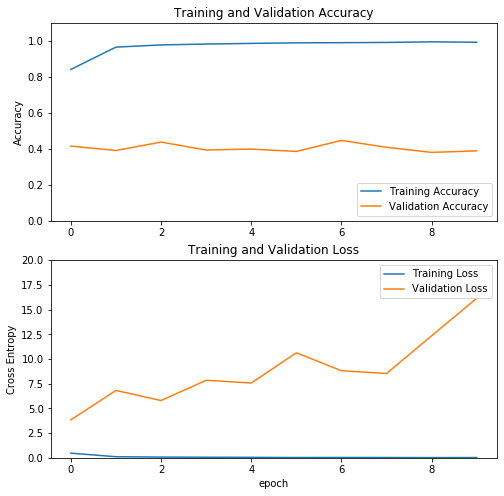

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([min(plt.ylim()),1])
plt.ylim([0,1.1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.ylim([0,20])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Guardando el modelo

In [16]:
saved_model_dir = 'model_InceptionResNetV2'
tf.saved_model.save(model, saved_model_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_InceptionResNetV2/assets


## Convirtiendo el modelo en tensorflow lite para el uso en mobile

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

path_tensorflow_lite = 'model_tflite/model_InceptionResNetV2.tflite'
with open(path_tensorflow_lite, 'wb') as f:
  f.write(tflite_model)

# Tomando 25 imágenes de validación y observando el resultado

In [ ]:
test_data = ImageClassifierDataLoader.from_folder(path_test_validation)

def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(test_data.dataset.take(100)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    swapped = np.moveaxis(image, 0, 1)
    arr4d = np.expand_dims(swapped, 0)
    id_predict = np.argmax(model.predict(arr4d))
    
    predict_label = "100"
    if id_predict == 1:
        predict_label = "20"
    color = get_label_color(predict_label, test_data.index_to_label[label.numpy()])
    #color = 'black'
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()